# Objectives

1. Plot Subtrees: Phylo
1. Plot Subtrees: Map

---
# Setup

## Imports

In [1]:
import os
import dill
from Bio import Phylo
import copy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj, transform
import math

## Variables

In [2]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "geo"
PREV_DIR = "locus_coverage/all"
PREV_NAME = "locus_coverage"

GEO_ATTR = "Mugration_Province"
PLOT_ATTR = "Mugration_Branch_Number"
COL_ATTR = "Mugration_Branch_Major"

## File Paths

In [3]:
# jupyter notebook output
aln_path     = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
tree_df_dill = "../../results/{}/{}.df.obj".format(PREV_DIR, PREV_NAME)
tree_dill    = "../../results/{}/{}_timetree.treetime.obj".format(PREV_DIR, PREV_NAME)

# Auspice
auspice_latlon_path     = "../../results/parse_tree/parse_tree_latlon.tsv"
auspice_colors_path     = "../../results/parse_tree/parse_tree_colors.tsv"
auspice_config_path     = "../../config/auspice_config.json"
auspice_remote_dir_path = "../../auspice/"

# Output
outdir = "../../results/{}/".format(SCRIPT_NAME)

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Import Tree

In [4]:
with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

## Import Dataframe

In [5]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
display(tree_df)

UFboot   sCF Branch_Length Branch_Support_Color      coord_x  \
Name                                                                          
NODE0             100    NA             0                black  2.14881e-07   
SAMEA3541827       NA    NA    3.8504e-06                 grey  3.43983e-06   
NODE1             100    85   1.32708e-05                black  8.39127e-06   
SAMEA104233046     NA    NA    2.2484e-06                 grey  1.05415e-05   
NODE2             100  94.6   1.36364e-05                black  2.28244e-05   
...               ...   ...           ...                  ...          ...   
NODE_0000360       NA    NA            NA                   NA  6.56282e-05   
NODE_0000453       NA    NA            NA                   NA  6.41238e-05   
NODE_0000477       NA    NA            NA                   NA  6.77776e-05   
NODE_0000478       NA    NA            NA                   NA  6.77776e-05   
NODE_0000479       NA    NA            NA                   NA  6.77776e-05   

                coord_y      Strain           Date         DateBP    Country  \
Name                                                                           
NODE0           16.1893          NA             NA             NA         NA   
SAMEA3541827          1     RISE509  [-2876:-2677]  [-4897:-4698]     Russia   
NODE1           3.15625          NA             NA             NA         NA   
SAMEA104233046        2  Gyvakarai1  [-2621:-2472]  [-4642:-4493]  Lithuania   
NODE2            4.3125          NA             NA             NA         NA   
...                 ...         ...            ...            ...        ...   
NODE_0000360      541.5          NA             NA             NA         NA   
NODE_0000453      554.5          NA             NA             NA         NA   
NODE_0000477    592.875          NA             NA             NA         NA   
NODE_0000478     593.75          NA             NA             NA         NA   
NODE_0000479      594.5          NA             NA             NA         NA   

                        Province CountryLat CountryLon ProvinceLat  \
Name                                                                 
NODE0                         NA         NA         NA          NA   
SAMEA3541827    Krasnoyarsk Krai    64.6863    97.7453     63.3234   
NODE1                         NA         NA         NA          NA   
SAMEA104233046  Panevezys County      55.35      23.75     55.9156   
NODE2                         NA         NA         NA          NA   
...                          ...        ...        ...         ...   
NODE_0000360                  NA         NA         NA          NA   
NODE_0000453                  NA         NA         NA          NA   
NODE_0000477                  NA         NA         NA          NA   
NODE_0000478                  NA         NA         NA          NA   
NODE_0000479                  NA         NA         NA          NA   

               ProvinceLon      Biovar Branch_Major Branch_Minor  \
Name                                                               
NODE0                   NA          NA           NA           NA   
SAMEA3541827        97.098  Bronze Age        0.PRE       0.PRE2   
NODE1                   NA          NA           NA           NA   
SAMEA104233046     25.0312  Bronze Age        0.PRE       0.PRE1   
NODE2                   NA          NA           NA           NA   
...                    ...         ...          ...          ...   
NODE_0000360            NA          NA           NA           NA   
NODE_0000453            NA          NA           NA           NA   
NODE_0000477            NA          NA           NA           NA   
NODE_0000478            NA          NA           NA           NA   
NODE_0000479            NA          NA           NA           NA   

                     BioSample   BioSampleComment Branch_Number  \
Name                                                              
NODE0           

In [6]:
# Remove Bad Samples

# CDC : GCA_002529545.1_ASM252954v1_genomic
# Drop CDC Sample: GCA_002529545.1_ASM252954v1_genomic
node = tt.tree.common_ancestor("GCA_002529545.1_ASM252954v1_genomic")
parent = node.up
tt.tree.prune(node)
tree_df.drop(node.name, inplace=True)
tree_df.drop(parent.name, inplace=True)

## Convert Dataframe to Geopandas

In [7]:
#df = tree_df[tree_df[GEO_ATTR + "_Lon"] != NO_DATA_CHAR]
geometry = []
for rec in tree_df.iterrows():
    sample = rec[0]
    geo_attr = "Province"
    # 1) Is this a tip?
    if rec[1]["Branch_Support_Color"] == TERM_COL:
        # 2) Does this tip have province data?
        if rec[1]["Province"] == NO_DATA_CHAR and rec[1]["Country"] != "Russia":
            geo_attr = "Country"
    x,y = tree_df["Mugration_" + geo_attr + "_Lon"][sample], tree_df["Mugration_" + geo_attr + "_Lat"][sample]
    geometry.append(shapely.geometry.Point(x,y))
    
#geometry = [shapely.geometry.Point(xy) for xy in zip(tree_df[GEO_ATTR + "_Lon"], tree_df[GEO_ATTR + "_Lat"])]
#df.drop([GEO_ATTR + "_Lon", GEO_ATTR + "_Lat"], axis=1, inplace=True)
#WGS84 = "epsg:4326"
tree_gdf = geopandas.GeoDataFrame(tree_df, crs=CRS, geometry=geometry)
display(tree_gdf)

UFboot   sCF Branch_Length Branch_Support_Color      coord_x  \
Name                                                                          
NODE0             100    NA             0                black  2.14881e-07   
SAMEA3541827       NA    NA    3.8504e-06                 grey  3.43983e-06   
NODE1             100    85   1.32708e-05                black  8.39127e-06   
SAMEA104233046     NA    NA    2.2484e-06                 grey  1.05415e-05   
NODE2             100  94.6   1.36364e-05                black  2.28244e-05   
...               ...   ...           ...                  ...          ...   
NODE_0000360       NA    NA            NA                   NA  6.56282e-05   
NODE_0000453       NA    NA            NA                   NA  6.41238e-05   
NODE_0000477       NA    NA            NA                   NA  6.77776e-05   
NODE_0000478       NA    NA            NA                   NA  6.77776e-05   
NODE_0000479       NA    NA            NA                   NA  6.77776e-05   

                coord_y      Strain           Date         DateBP    Country  \
Name                                                                           
NODE0           16.1893          NA             NA             NA         NA   
SAMEA3541827          1     RISE509  [-2876:-2677]  [-4897:-4698]     Russia   
NODE1           3.15625          NA             NA             NA         NA   
SAMEA104233046        2  Gyvakarai1  [-2621:-2472]  [-4642:-4493]  Lithuania   
NODE2            4.3125          NA             NA             NA         NA   
...                 ...         ...            ...            ...        ...   
NODE_0000360      541.5          NA             NA             NA         NA   
NODE_0000453      554.5          NA             NA             NA         NA   
NODE_0000477    592.875          NA             NA             NA         NA   
NODE_0000478     593.75          NA             NA             NA         NA   
NODE_0000479      594.5          NA             NA             NA         NA   

                        Province CountryLat CountryLon ProvinceLat  \
Name                                                                 
NODE0                         NA         NA         NA          NA   
SAMEA3541827    Krasnoyarsk Krai    64.6863    97.7453     63.3234   
NODE1                         NA         NA         NA          NA   
SAMEA104233046  Panevezys County      55.35      23.75     55.9156   
NODE2                         NA         NA         NA          NA   
...                          ...        ...        ...         ...   
NODE_0000360                  NA         NA         NA          NA   
NODE_0000453                  NA         NA         NA          NA   
NODE_0000477                  NA         NA         NA          NA   
NODE_0000478                  NA         NA         NA          NA   
NODE_0000479                  NA         NA         NA          NA   

               ProvinceLon      Biovar Branch_Major Branch_Minor  \
Name                                                               
NODE0                   NA          NA           NA           NA   
SAMEA3541827        97.098  Bronze Age        0.PRE       0.PRE2   
NODE1                   NA          NA           NA           NA   
SAMEA104233046     25.0312  Bronze Age        0.PRE       0.PRE1   
NODE2                   NA          NA           NA           NA   
...                    ...         ...          ...          ...   
NODE_0000360            NA          NA           NA           NA   
NODE_0000453            NA          NA           NA           NA   
NODE_0000477            NA          NA           NA           NA   
NODE_0000478            NA          NA           NA           NA   
NODE_0000479            NA          NA           NA           NA   

                     BioSample   BioSampleComment Branch_Number  \
Name                                                              
NODE0           

# Import Colors

In [8]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)
display(colors_df)

colors_dict = {}
# Convert to dict

for rec in colors_df.iterrows():
    attr = rec[1]["Attribute"]
    state = rec[1]["State"]
    color = rec[1]["Color"]
    if attr not in colors_dict:
        colors_dict[attr] = {}
    colors_dict[attr][state] = color

Attribute                 State    Color
0    branch_number                     0  #8000ff
1    branch_number                     3  #00b4ec
2    branch_number                     4  #80ffb4
3    branch_number                     2  #ffb462
4    branch_number                     1  #ff0000
..             ...                   ...      ...
202       province              Midlands  #ff1c0e
203       province  State of Mato Grosso  #ff150b
204       province                 MSila  #ff0e07
205       province                La Paz  #ff0704
206       province             Cajamarca  #ff0000

[207 rows x 3 columns]

---
# 1. Plot Subtrees: Phylogeny

## Calculate Size by Location

In [9]:
tip_gdf = tree_gdf[tree_gdf["Branch_Support_Color"] == TERM_COL]

# Sizes
marker_scale = 2
marker_size = 20
geom_sizes = {}
tt_copy = copy.deepcopy(tt)
for t in tt_copy.tree.get_terminals():
    geometry = str(tree_gdf["geometry"][t.name])
    if geometry not in geom_sizes:
        geom_sizes[geometry] = 1
    else:
        geom_sizes[geometry] += 1

## Construct

In [10]:
tt_copy = copy.deepcopy(tt)


branch_dict = {
    key : {
        "clade" : None,
        "gdf"   : None,
    } 
    for key in colors_dict["branch_major"].keys()}

for branch in branch_dict:
    #if branch != "1.ANT": continue
    print("Working on branch:", branch)
    target_gdf = copy.deepcopy(tree_gdf)    
    target_nodes = tree_gdf[tree_gdf["Mugration_Branch_Major"] == branch]
    # Add one level up to target nodes    
    target_mrca = tt_copy.tree.common_ancestor(target_nodes.index).up
    # If there's actually an upper node
    if target_mrca:
        mrca_rec = target_gdf[target_gdf.index.str.contains(target_mrca.name)]
        target_nodes = target_nodes.append(mrca_rec)
    # else reset to lower
    else:
        target_mrca = tt_copy.tree.common_ancestor(target_nodes.index)
    target_clade = copy.deepcopy(target_mrca)

    # Create a filtered df
    for rec in tree_df.iterrows():
        sample = rec[0]
        if sample not in target_nodes.index:
            target_gdf.drop(sample, inplace=True)
    branch_dict[branch]["gdf"] = target_gdf

    # Search for the nodes, finding tips to prune
    for c in target_mrca.find_clades(order="postorder"):
        cur_term = [t.name for t in target_clade.get_terminals()]    
        if c.name not in target_nodes.index:
            if c.name in cur_term:
                target_clade.collapse(target=c.name)
                
    # Color branches
    for c in target_clade.find_clades():
        state = tree_df["Mugration_Branch_Major"][c.name]
        color = colors_dict["branch_major"][state]
        c.color = color

    # Assign the sub tree to the dict
    branch_dict[branch]["clade"] = target_clade

Working on branch: 0.PRE
Working on branch: 0.PE
Working on branch: 0.ANT
Working on branch: 3.ANT
Working on branch: 4.ANT
Working on branch: 2.ANT
Working on branch: 2.MED
Working on branch: 1.PRE
Working on branch: 1.ANT
Working on branch: 1.IN
Working on branch: 1.ORI


## Plot

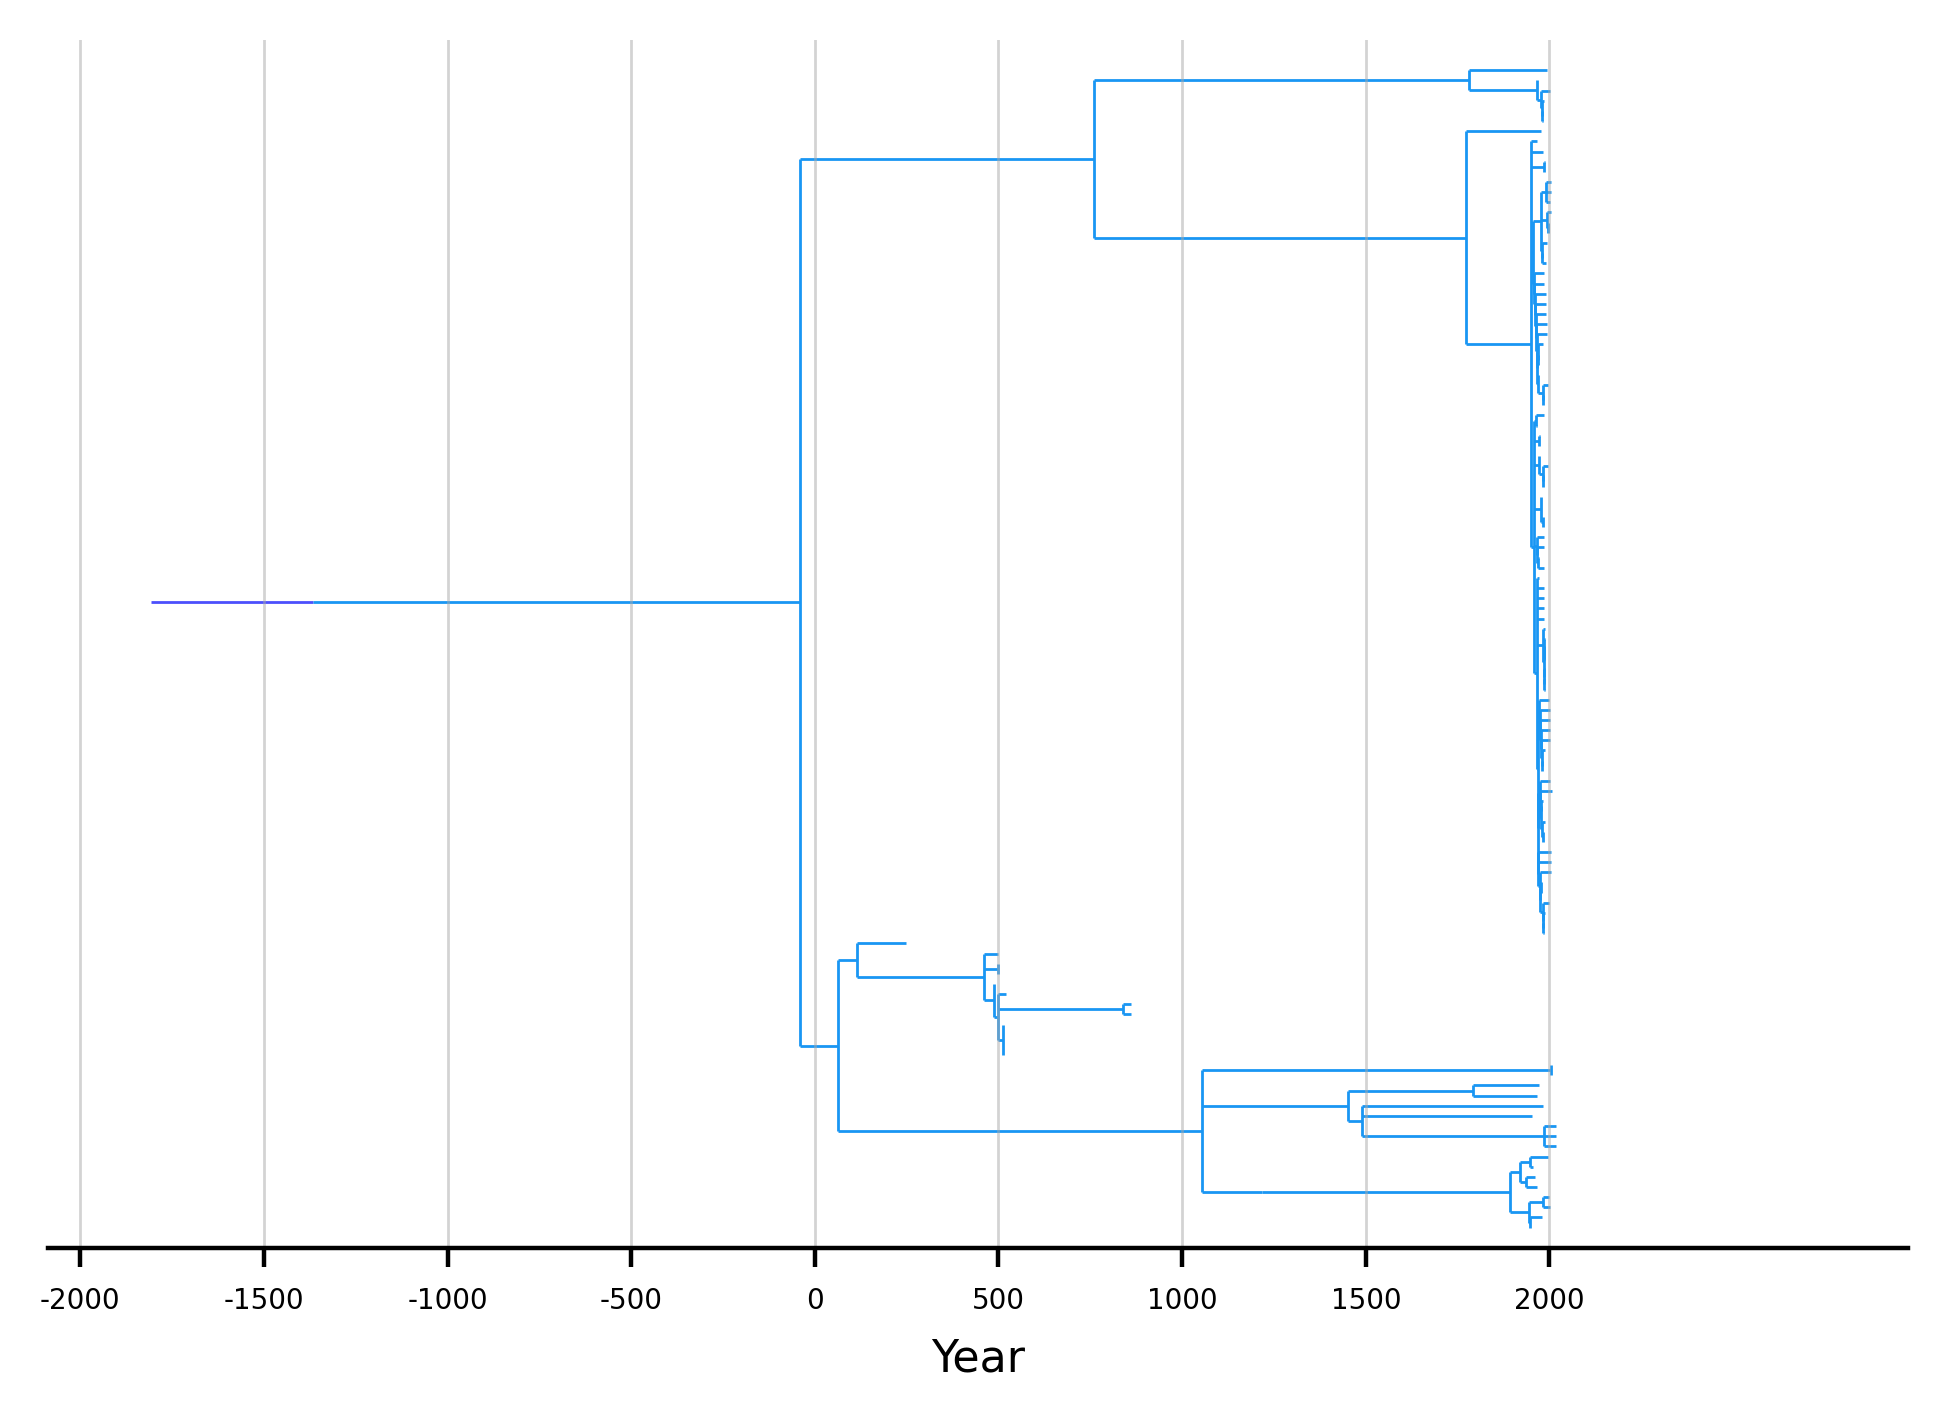

In [14]:
for branch in branch_dict:
    if branch != "0.ANT" : continue
    tree = branch_dict[branch]["clade"]
    gdf = branch_dict[branch]["gdf"]
    fig, ax1 = plt.subplots(1, dpi=dpi)
    
    if len(tree.get_terminals()) < 50:
        plt.rc("lines", linewidth=1)
    else:
        plt.rc("lines", linewidth=0.5)
        
    Phylo.draw(tree,
                 axes=ax1,
                 show_confidence=False, 
                 #label_func = (lambda x: "{} ({})".format(
                 #        tree_gdf["Strain"][x.name] + " ", 
                 #        tree_gdf["Country"][x.name]) 
                 #    if x.is_terminal() else ''),
                 label_func = lambda x: '',
                 do_show=False,
                )
    
    ax1.set_title("")
    ax1.set_ylabel("")
    ax1.set_yticks([])
    ax1.set_xlabel("Year")
    # --------------------------------------------
    # Ticks
    ticks_dict = convert_timetree_ticks(tree=tree, step=500)
    # Set the new tick locations and labels
    # Leave out last one
    ax1.set_xticks(ticks_dict["tick_locs"][:])
    ax1.set_xticklabels(ticks_dict["tick_labels"][:])

    # --------------------------------------------
    # Lines
    # Vertical lines for dates
    for loc in ticks_dict["tick_locs"][:]:
        ax1.axvline(x=loc, color="darkgrey", alpha=0.5)
        
    x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.07)
    y_buffer = math.ceil(len(tree.get_terminals()) * 0.01)

    ax1.set_xlim(0 - x_buffer,)    
    ax1.set_ylim(len(tree.get_terminals()) + y_buffer, 0 - y_buffer)
    ax1.set_yticks([])  
    
    # --------------------------------------------
    # Frames
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    
    out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree_{}.{}".format(branch, FMT)) 
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 2. Plot Subtrees: Map

## Node Sizes by Location

In [ ]:
sizes_dict = {}

for rec in tree_gdf.iterrows():
    sample = rec[0]
    geom = str(rec[1]["geometry"])
    if geom not in sizes_dict:
        sizes_dict[geom] = 0
    sizes_dict[geom] += 1

## Map

Working on branch: 0.PRE
Working on branch: 0.PE
Working on branch: 0.ANT
Working on branch: 3.ANT
Working on branch: 4.ANT
Working on branch: 2.ANT
Working on branch: 2.MED
Working on branch: 1.PRE
Working on branch: 1.ANT
Working on branch: 1.IN
Working on branch: 1.ORI


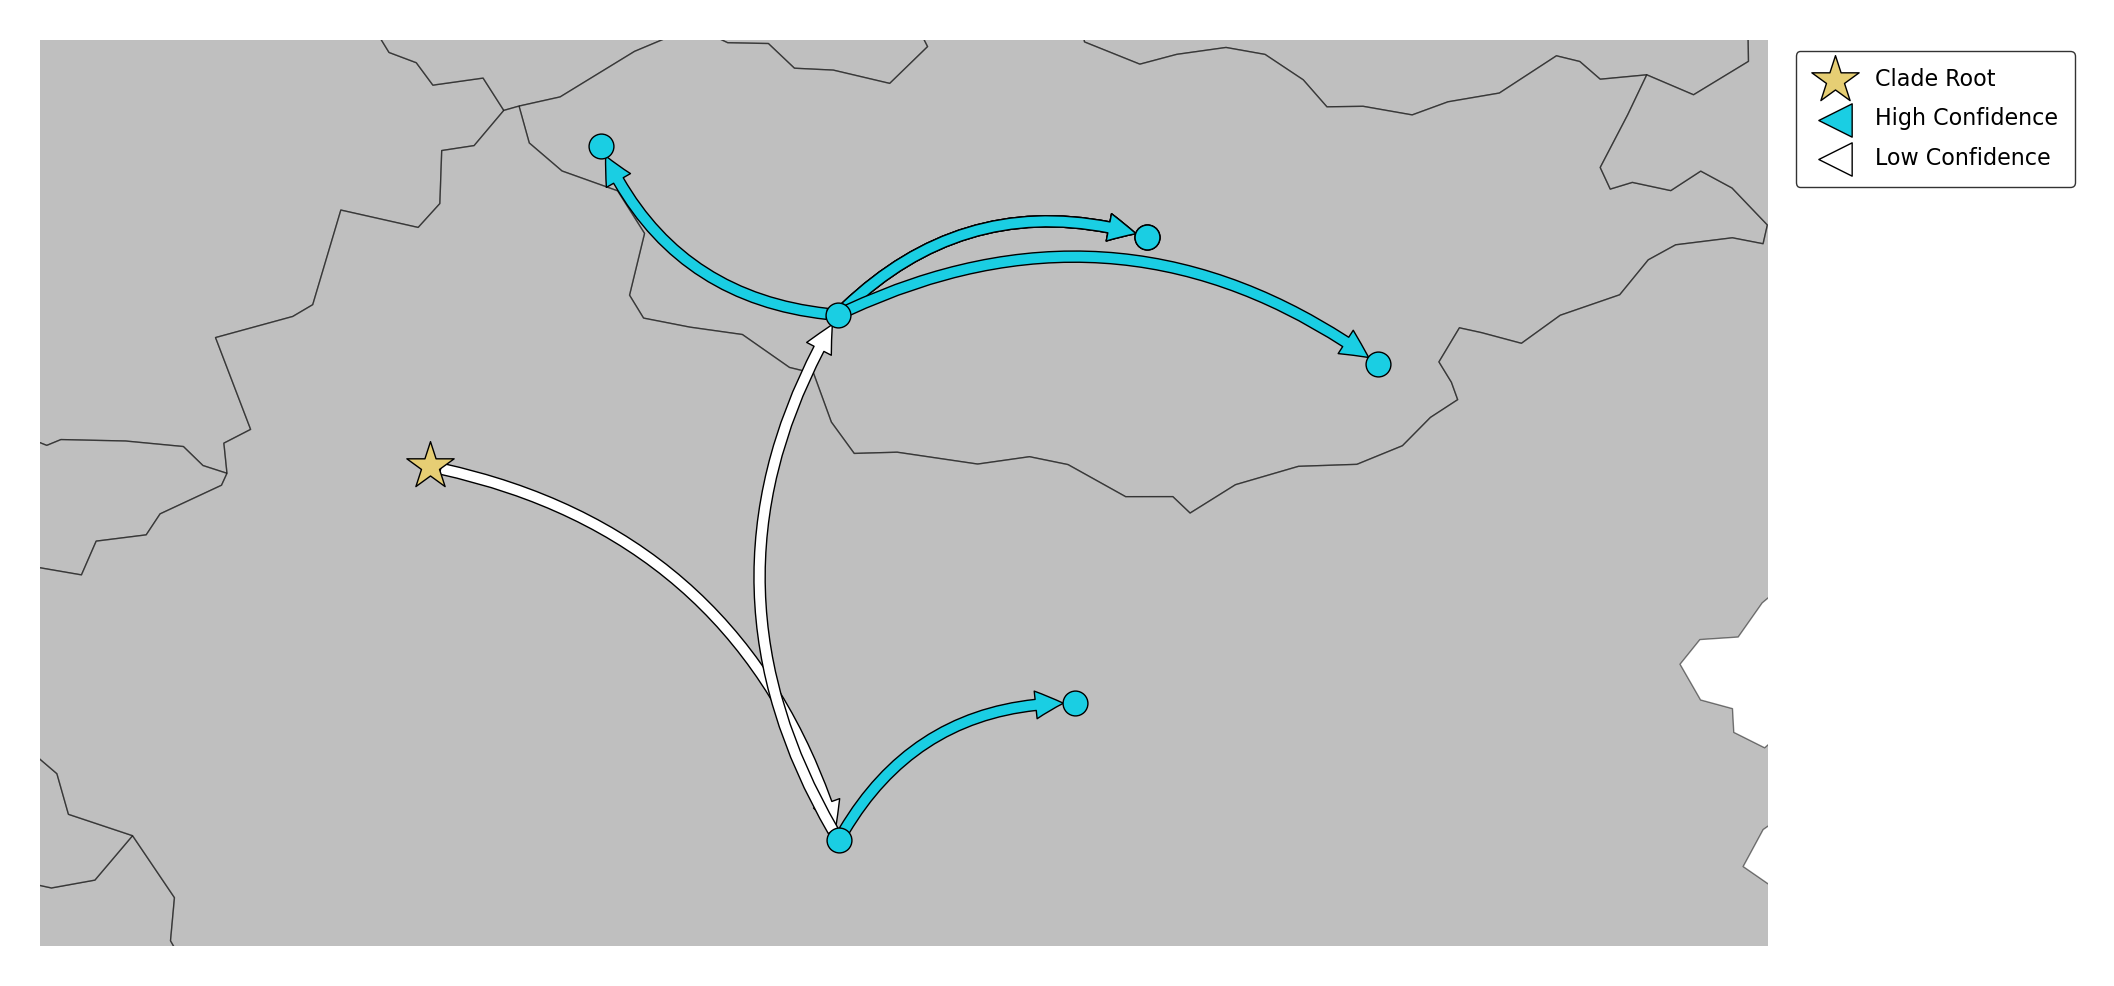

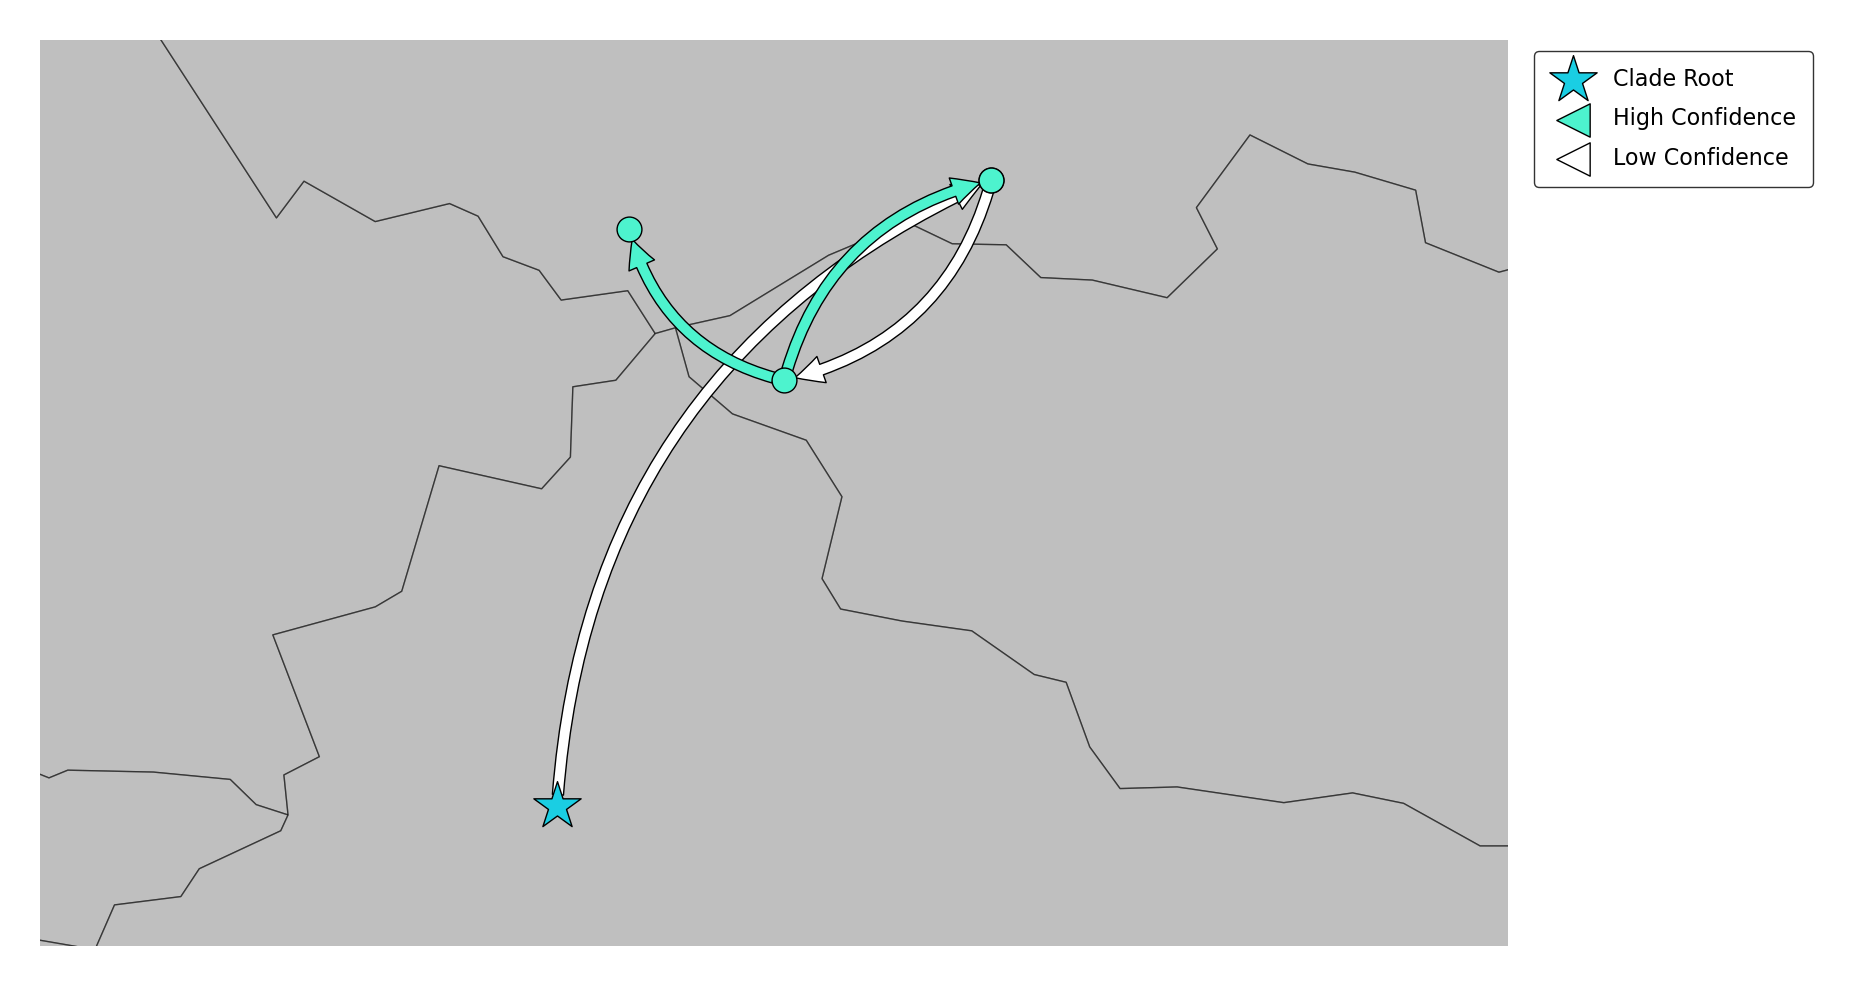

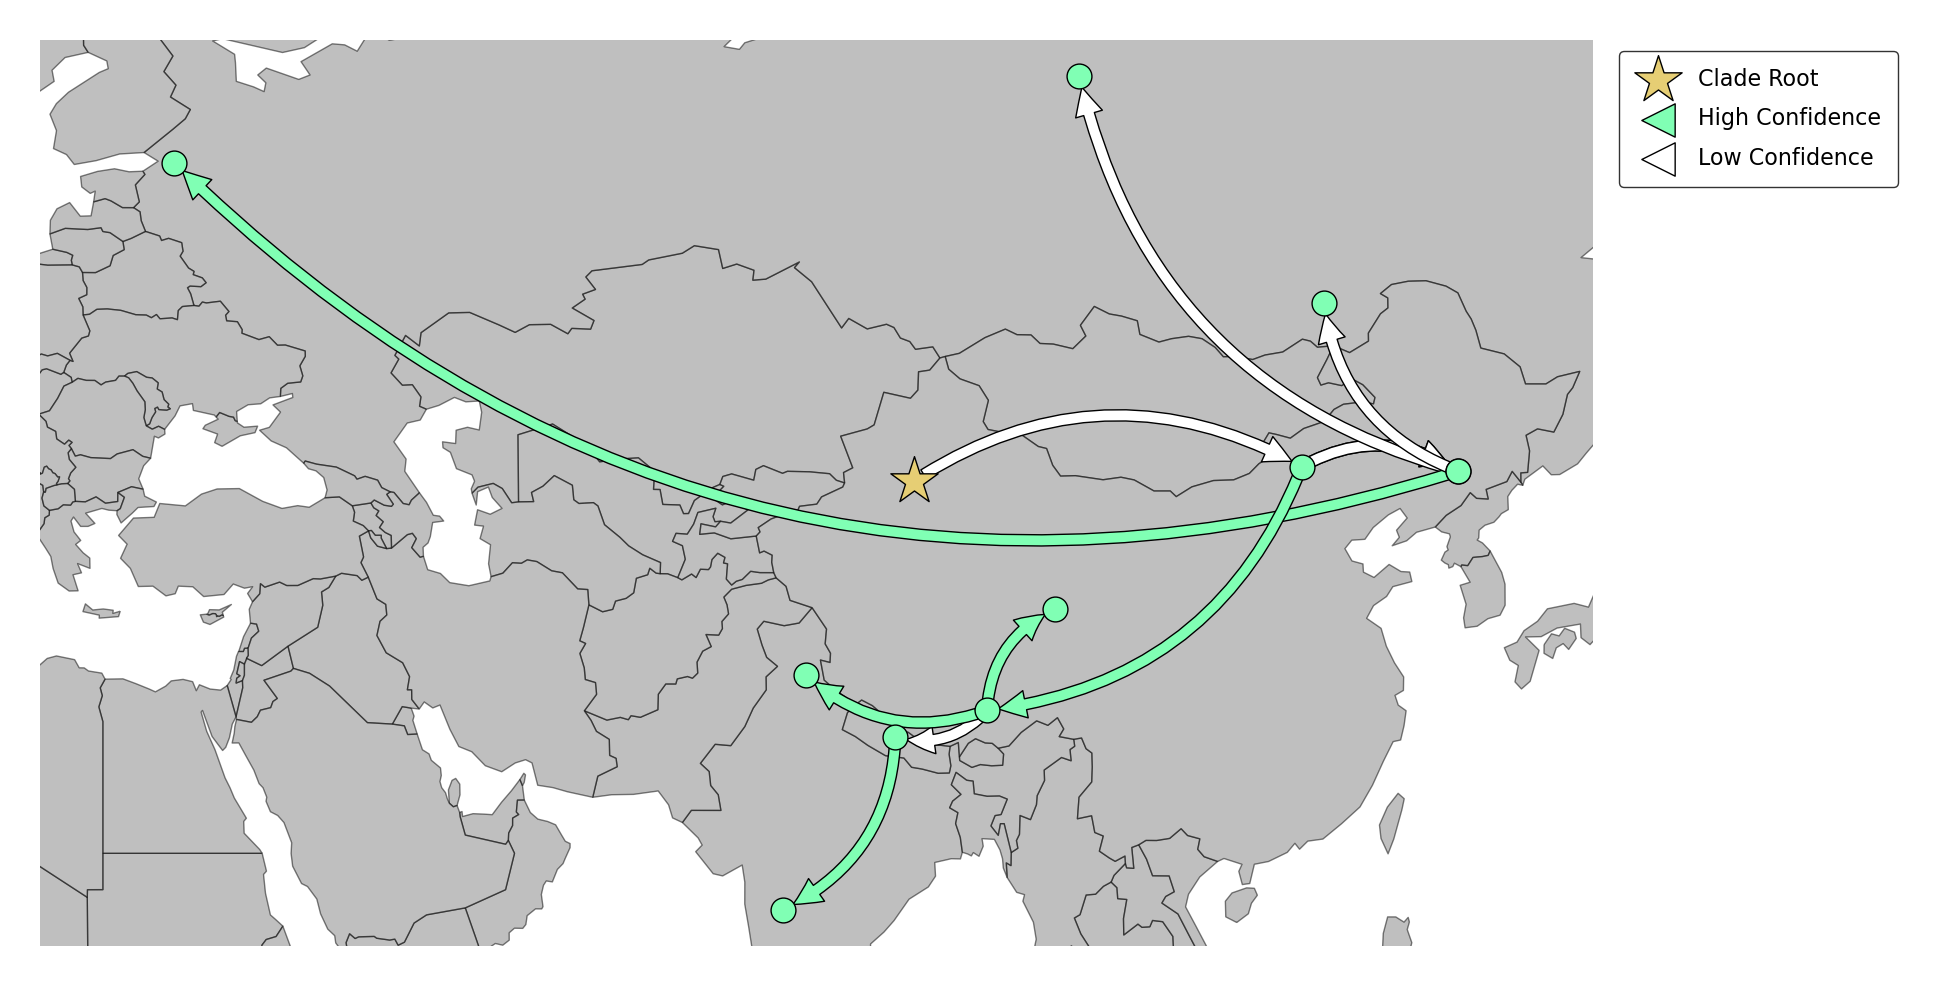

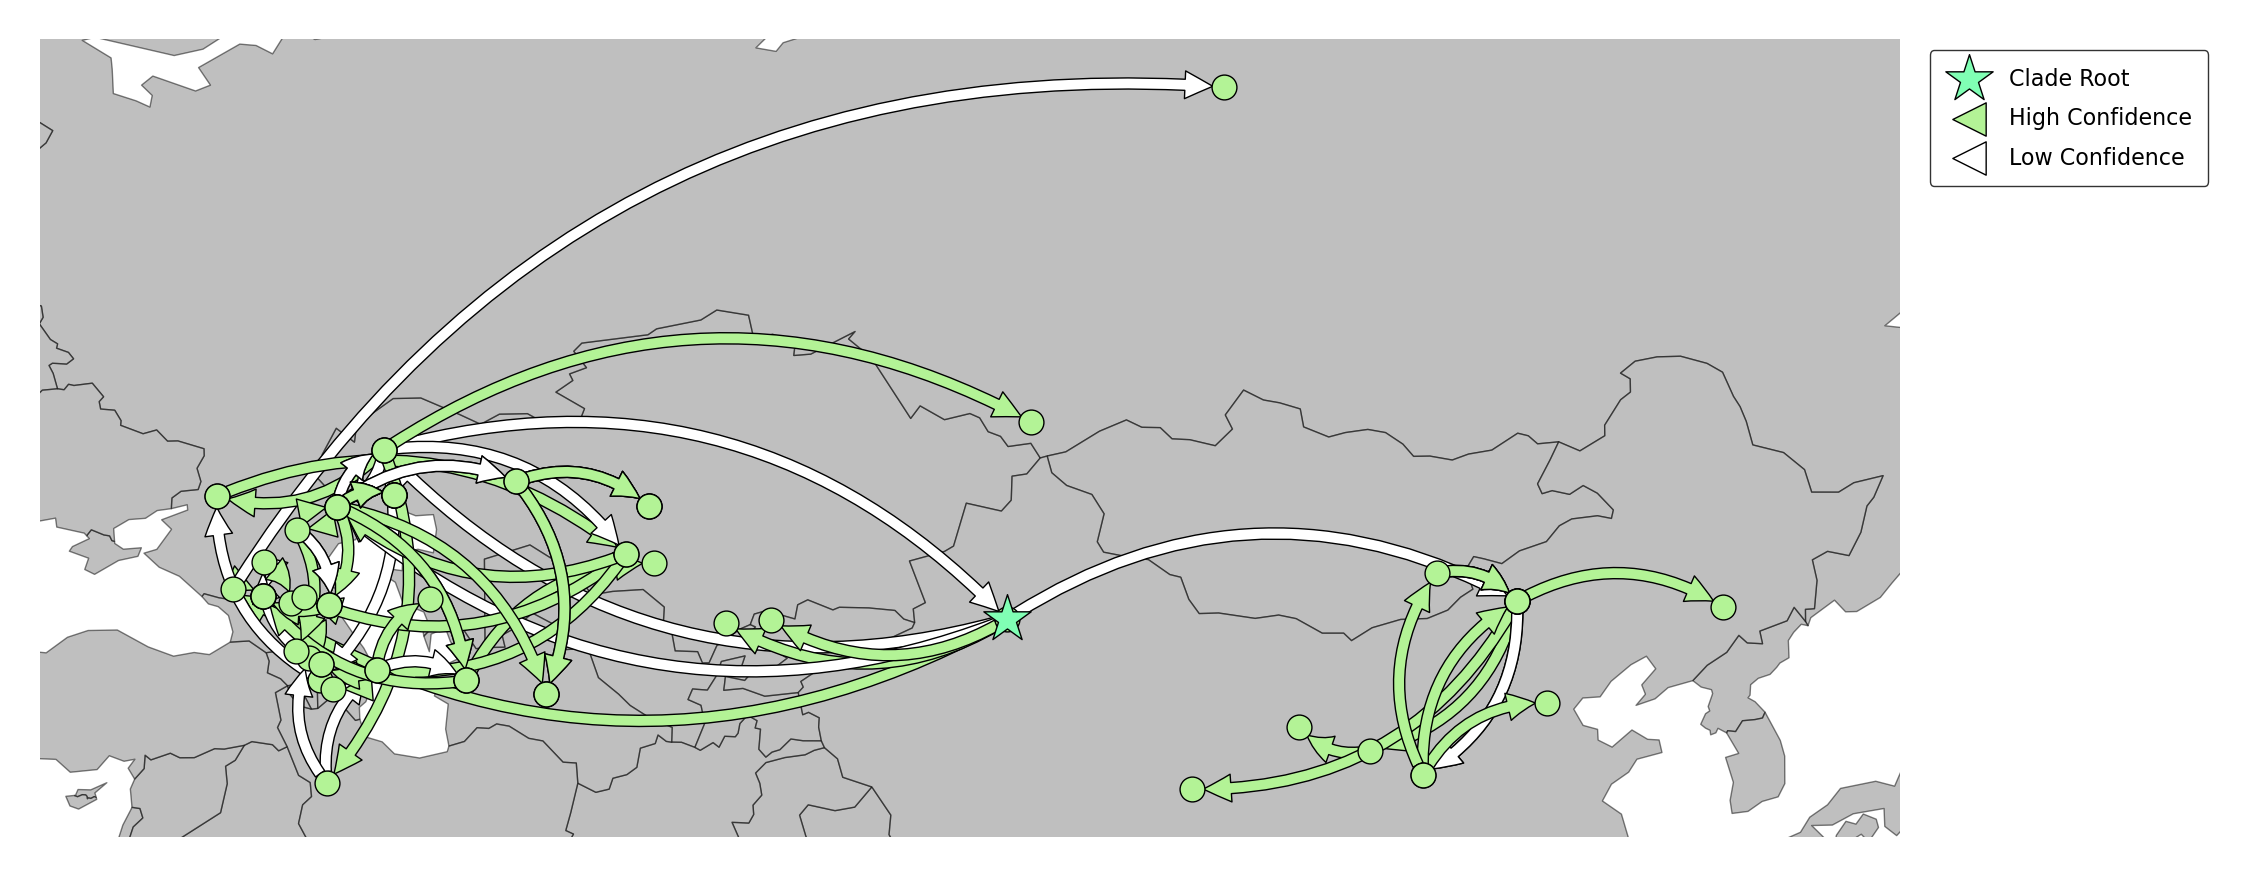

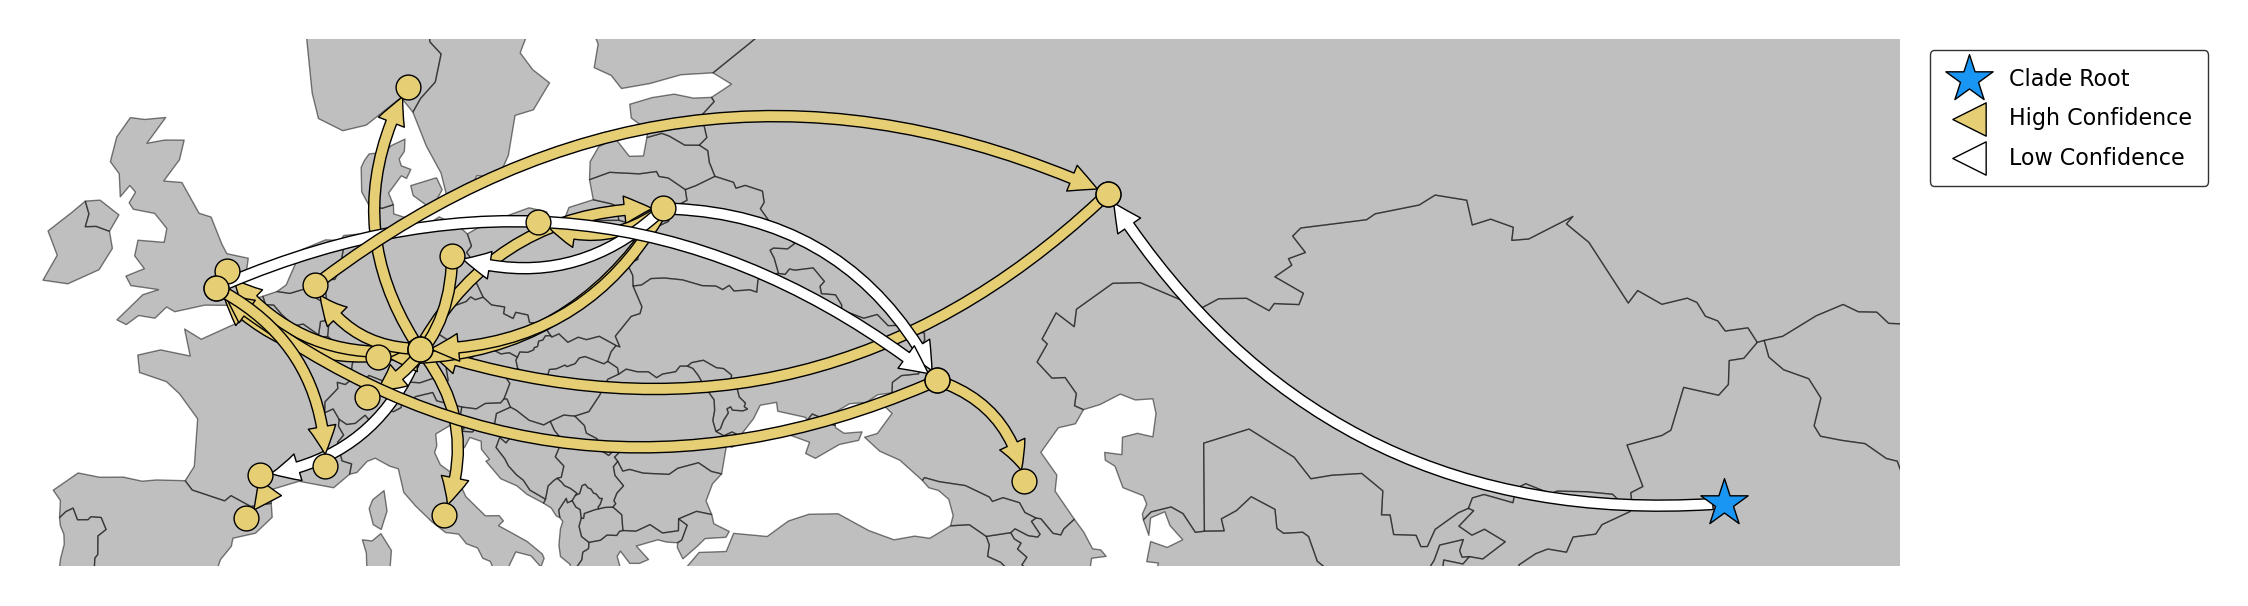

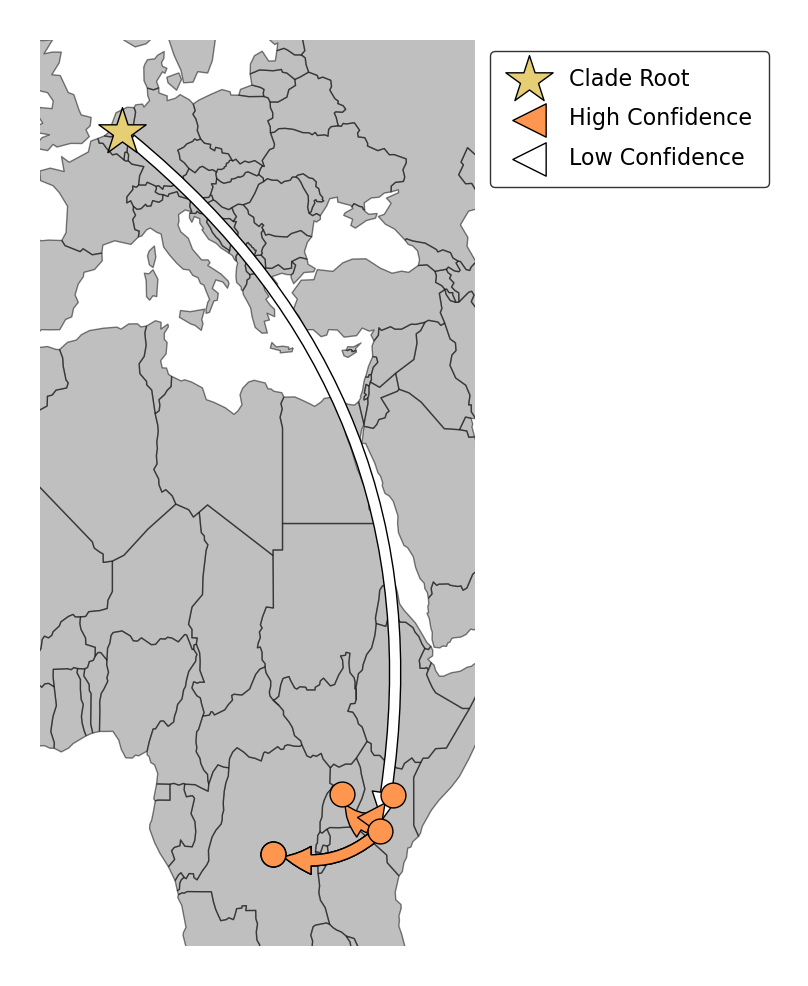

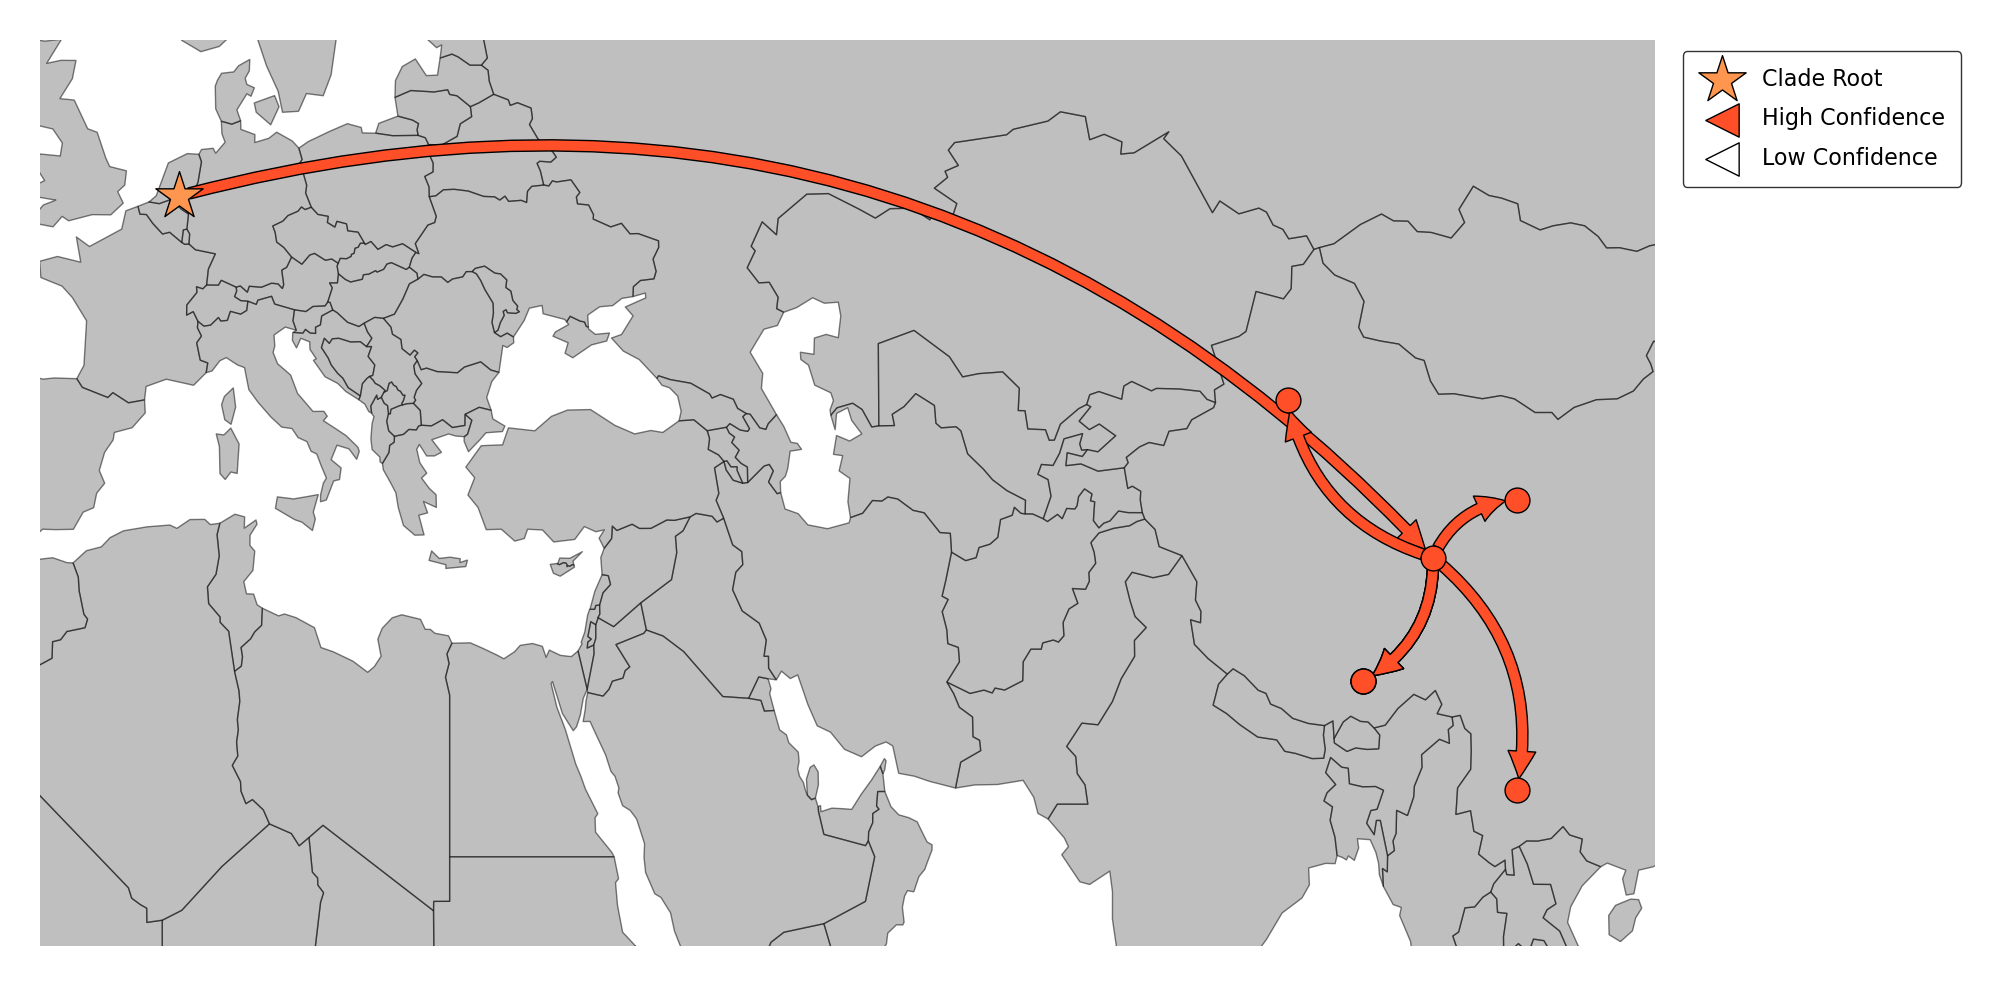

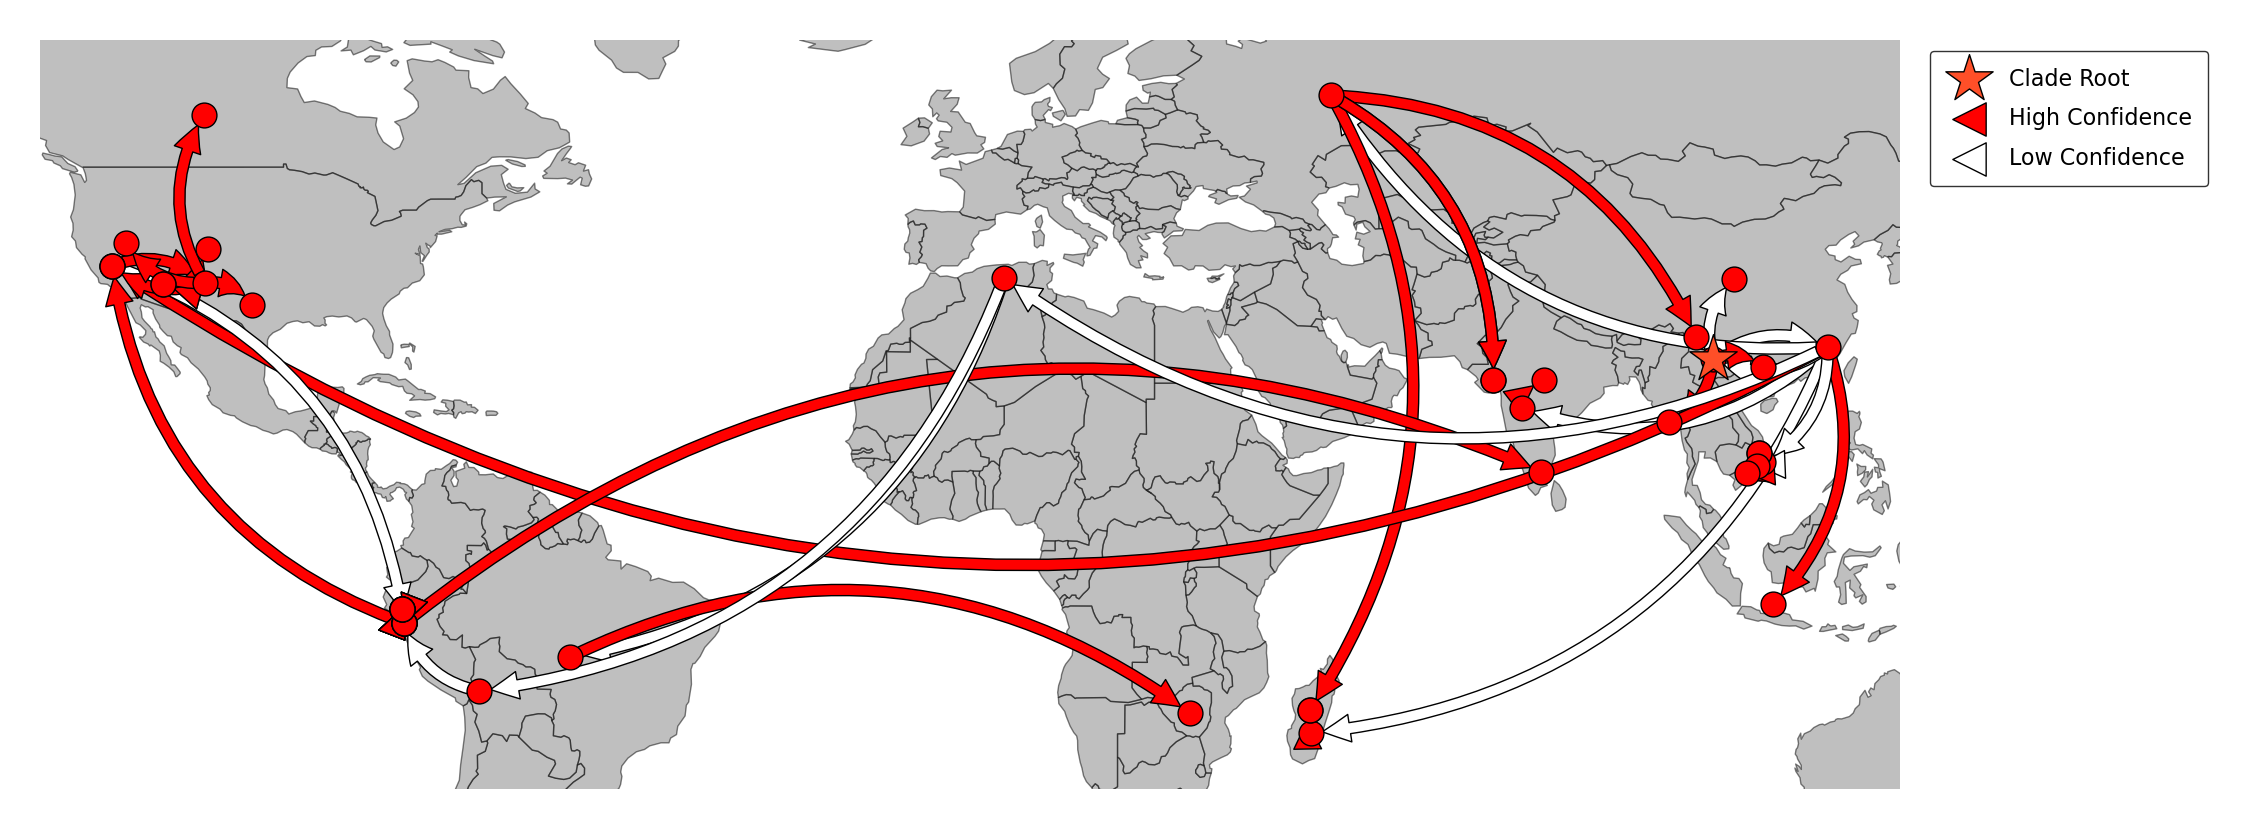

In [18]:
for branch in branch_dict:
    print("Working on branch:", branch)
    #if branch != "4.ANT": continue
    #if "0" not in branch: continue
    fig, ax1 = plt.subplots(1, dpi=dpi, figsize=(6,3))
    # --------------------------------------
    # World Basemap
    world_poly = world_polygons.plot(ax=ax1, 
                        zorder=1, 
                        alpha=0.5, 
                        color="grey",
                        edgecolor="black", 
                        linewidth=0.25,
                       )
    
    gdf = branch_dict[branch]["gdf"]
    tree = branch_dict[branch]["clade"]
    

    # Store node connections
    connect_list = []
    
    # If this subtree excludes the true root, manually add its connections
    if not tree.root.up:
        for c in tree.find_clades():
            if c.up and c.up.name == tree.root.name:
                connect_list.append([tree.root.name, c.name])
    for t in tree.get_terminals():
        # Check for an upper node
        if tree.root.up:
            path = tree.up.get_path(t)
        else:
            path = tree.get_path(t)
            
        for i in range(0, len(path) -1):
            connection = [path[i].name, path[i+1].name]
            # Don't store duplicate connections
            if connection not in connect_list:
                connect_list.append(connection)
    
    # Plot connections
    for connection in connect_list:
        origin = gdf[gdf.index.str.contains(connection[0])]
        dest = gdf[gdf.index.str.contains(connection[1])]
        origin_geom = origin["geometry"][0]
        dest_geom = dest["geometry"][0]
        dest_state = dest["Mugration_Branch_Major"][0]
        dest_color = colors_dict["branch_major"][dest_state]
        arrow_color = "white"
        # Check if using province or country
        geo_attr = "Province"
        if dest["Branch_Support_Color"][0] == TERM_COL:
            if dest["Province"][0] == NO_DATA_CHAR and dest["Country"][0] != "Russia":
                geo_attr = "Country"   
        dest_confidence = dest["Mugration_" + geo_attr + "_Confidence"][0]
        if dest_confidence >= MUG_CONF_THRESH:
            arrow_color = dest_color
        # check if we're changing locations
        if origin_geom != dest_geom:
            # Plot the destination point
            dest.plot(ax=ax1, 
                  color = dest_color,
                  #markersize = sizes_dict[str(dest_geom)],
                  markersize = 20,
                  edgecolor = "black",
                  linewidths=0.25,    
                  zorder=2,
                  )
            # Plot the connection arrow
            ax1.annotate('', xy=(dest_geom.x, dest_geom.y), xytext=(origin_geom.x, origin_geom.y),
                xycoords='data',
                size=10,
                zorder=1,
                label="test",
                arrowprops=dict(facecolor=arrow_color, 
                                ec = 'black', 
                                lw=0.25,
                                arrowstyle="simple",
                                connectionstyle="arc3,rad=-0.3"))

    # Plot root location
    root_gdf = gdf[gdf.index.str.contains(tree.root.name)]
    state = root_gdf["Mugration_Branch_Major"].values[0]
    geom = root_gdf["geometry"].values[0]
    root_gdf.plot(ax=ax1, 
                  color = colors_dict["branch_major"][state],
                  #markersize = sizes_dict[str(geom)],
                  markersize = marker_size * 4,
                  marker = "*",
                  edgecolor = "black",
                  linewidths=0.25,  
                  zorder=2,
                  alpha=1,
                  label="Clade Root"
                  )
    
    
    ax1.scatter(x=1000,y=1000,ec="black", fc=dest_color, marker="<", lw=0.25, label="High Confidence")
    ax1.scatter(x=1000,y=1000,ec="black", fc="white", marker="<", lw=0.25, label="Low Confidence")

    
    # --------------------------------------
    # Limits
    
    # Get xlim from data
    x_min = 300
    x_max = -300
    y_min = 100
    y_max = -100
    range_x_min = 40
    for geom in branch_dict[branch]["gdf"]["geometry"]:
        if geom.x <= x_min:
            x_min = geom.x
        if geom.x > x_max:
            x_max = geom.x
        if geom.y <= y_min:
            y_min = geom.y
        if geom.y > y_max:
            y_max = geom.y
    
    x_buffer = 10
    y_buffer = 2
    
    # Manual adjustments
    if branch == "0.PRE" or branch == "1.ANT" or branch == "0.PE" or branch == "0.ANT" or branch == "1.IN" or branch == "1.ORI":
        y_buffer = 7
    ax1.set_xlim(x_min - x_buffer, x_max + x_buffer)
    ax1.set_ylim(y_min - y_buffer, y_max + y_buffer)

    # --------------------------------------
    # Labels
    ax1.axis('off')
    
    #ax1.set_title(branch, fontsize=SM_FONT)    
    # --------------------------------------
    # Legend
    legend = plt.legend(frameon=True, 
               edgecolor="black", 
               borderpad=0.75, 
               bbox_to_anchor=(1.01, 1), 
               loc='upper left',
               fontsize=4,)
    legend.get_frame().set_linewidth(0.25)  
    out_path = os.path.join(outdir, SCRIPT_NAME + "_spreadmap_{}.{}".format(branch, FMT)) 
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# Export

## Dataframe

In [ ]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)